# Tutorial 4

## Introducción a los Histogramas

En este tutorial estudiaremos a los histogramas como una fuente de información sobre la distribución de intensidades de una imagen. Sobre esta representación podemos operar para transformar dicha imagen y así adaptarla a un contexto específico. En este tutorial ahondaremos en las operaciones de ecualización, especificación y umbralización, haciendo especial énfasis en el método de umbralización de Otsu.

A continuación, cargaremos una imagen. Además, visualizaremos su histograma a partir de las funciones disponibles en las librerías de `numpy` y `matplotlib`:

In [ ]:
from skimage.io import imread
import numpy as np

# Leemos la imagen en escala de grises desde un archivo y la escalamos para que su representación sea de 8 bits
img = imread("dark_forest.jpg", as_gray=True) * 255
# Convertimos el arreglo de tipo punto flotante a tipo entero
img = img.astype(np.uint8)

# La función histogram de la librería numpy permite obtener el histograma de la imagen sin graficarlo:

# Obtenemos las frecuencias asociadas a cada intensidad de la imagen, es decir su histograma 
histogram, bin_edges = np.histogram(img, bins=range(0, 257))
# Normalizamos el histograma para que la suma de todas las frecuencias sea igual a 1
norm_histogram = histogram / np.sum(img)


print("Cada bin está definido por dos bordes consecutivos de la siguiente lista:")
print(bin_edges)
print("\n")
print("La frecuencia de cada intensidad está dada por la siguiente lista:")
print(histogram)
print("\n")
print("Las frecuencias normalizadas que representan una distribución de probabilidad son las siguientes:")
print(norm_histogram)
print("\n")

>**Ejercicio:** Revise la documentación `numpy.histogram`. Comprenda por qué tiene sentido escribir 257 en la linea de código
`histogram, bin_edges = np.histogram(img, bins=range(0, 257))`

In [ ]:
# La función `matplotlib.pyplot.hist` calcula y retorna los histogramas además de graficarlos
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(img, cmap = 'gray', vmin=0, vmax=255)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('Off')

plt.subplot(132)
plt.title("Histograma")

# Note que para graficar el histograma debe transformar la imagen en un vector de intensidades. Esto se puede
# realizar con el método flatten() de la clase ndarray

plt.hist(img.flatten(), bins = range(0, 257))
plt.ylabel("Frecuencia")
plt.xlabel("Intensidad")

plt.subplot(133)
plt.title("Histograma Normalizado")

# El parámetro density de la fucnión hist nos permite normalizar las frecuencias para que sumen 1.
plt.hist(img.flatten(), bins = range(0, 257), density = True)
plt.ylabel("Frecuencia")
plt.xlabel("Intensidad")

plt.tight_layout()
plt.show()


## Ecualización de Histogramas

Note que la imagen original es muy oscura. La mayor parte de las frecuencias de intensidad se encuentran agrupadas en la parte izquierda del histograma, es decir en intensidades bajas u oscuras. Si estuviésemos desarrollando un modelo que buscara detectar animales en este bosque oscuro, un preprocesamiento de las imágenes que podría mejorar nuestros resultados sería cambiar la distribución del histograma por una distribución uniforme, de tal forma que las intensidades agrupadas se distribuyan a lo largo de todo el rango dinámico disponible, aumentando el contraste entre las intensidades oscuras de la imagen original.

El proceso de ajustar la distribución de intensidades de una imagen para que su histograma se asemeje a una *distribución uniforme* se conoce como ecualización. Algorítmicamente, el proceso de ecualización de una imagen se puede resumir en los siguientes pasos:

1. Obtener la frecuencia ($n_r$) de cada intensidad original ($r_k$).
1. Calcular el valor de la función de distribución acumulada escalada por la intensidad máxima ($s_k$) asociada a cada intensidad original.
1. Aproximar cada valor de la función de distribución acumulada a un número entero ($s_k$ aprox.)
1. Mapear los píxeles de intensidad original a una intensidad equivalente. Esta será el valor asociado en la función de distribución acumulada. Esto resultará en unas nuevas frecuencias ($n_s$) semejantes a las de una distribución uniforme.

Este proceso se resume en el siguiente ejemplo con una imagen con una representación de 2 bits:
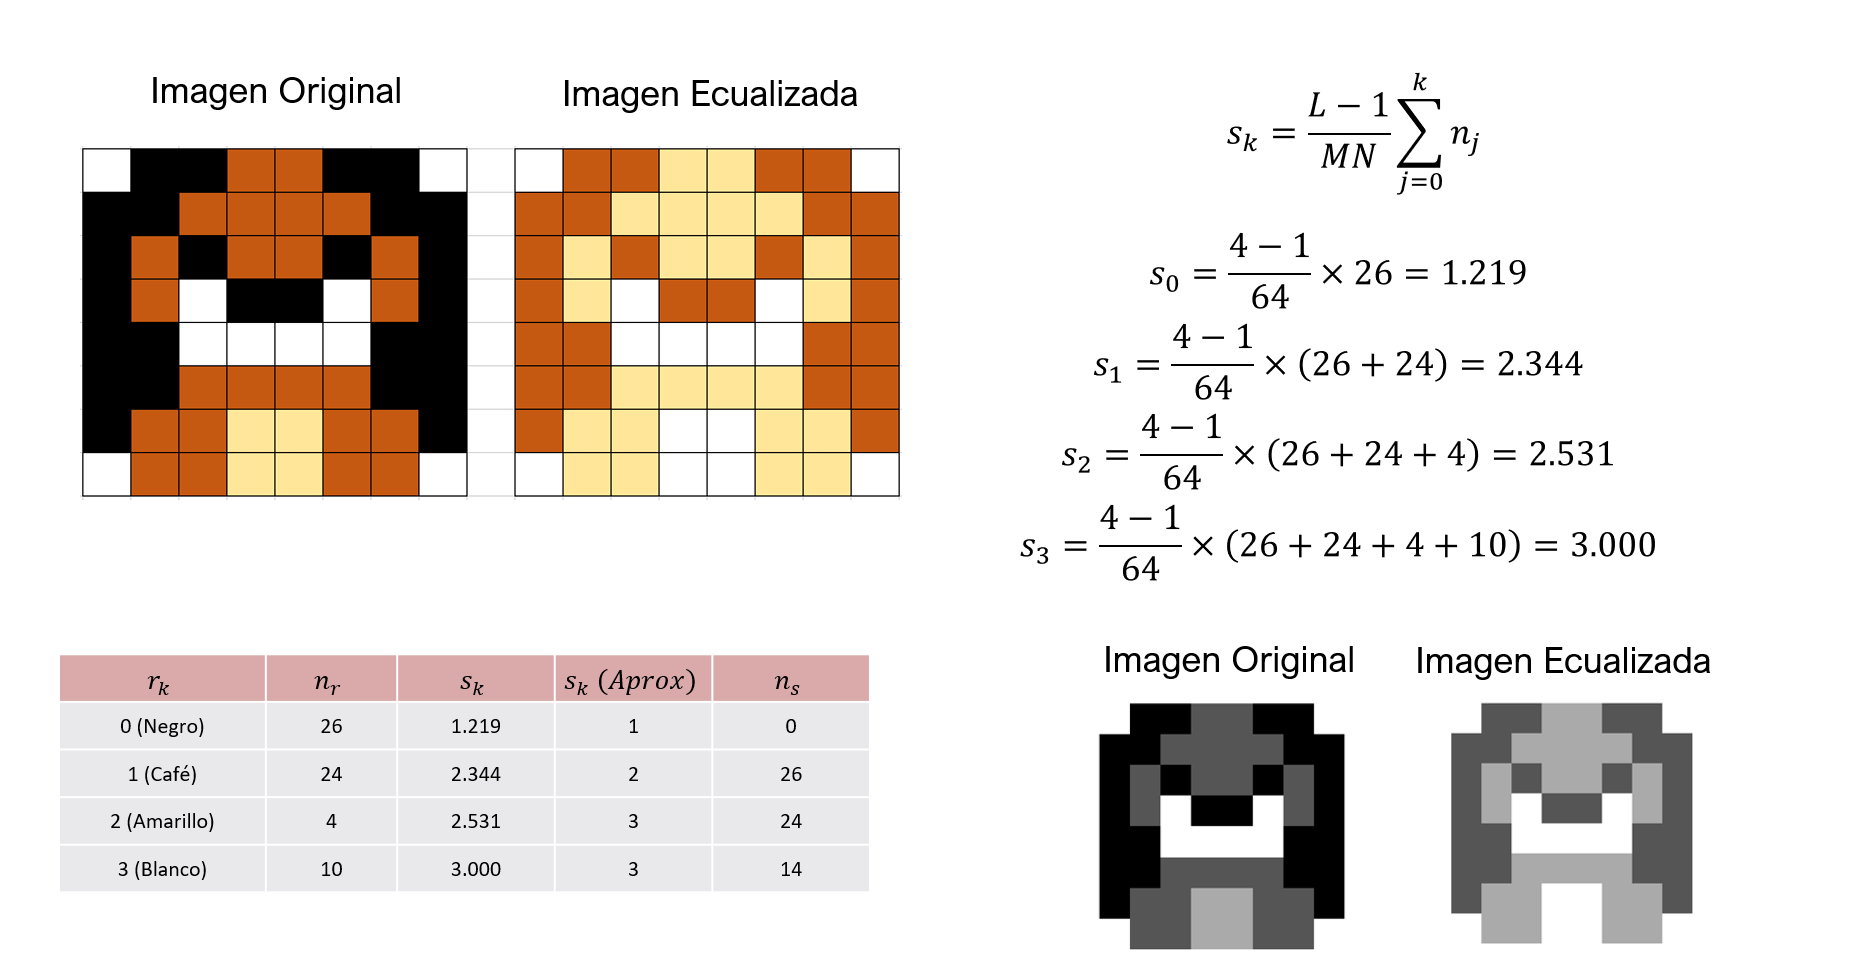

A continuación, se presenta una implementación de una función para ecualizar imágenes en escala de grises con intensidades representadas por 8 bits:

In [ ]:
def equalization(img):
    
    # Obtenemos las frecuencias de cada intensidad en la imagen original
    n_r, _ = np.histogram(img, bins=range(0, 257))
    
    # Definimos las intensidades asociadas a las frecuencias originales
    r_k = range(0, 256)
    
    # Calculamos la función de distribución acumulada escalada por la intensidad máxima para las frecuencias originales
    s_k = [(255/(img.shape[0] * img.shape[1])) * np.sum(n_r[0:i]) for i in range(len(n_r))]
    
    # Aproximamos la función de distribución acumulada escalada a números enteros y almacenamos los valores como
    # representación de 8 bits
    s_k_round = np.array(s_k).round().astype(np.uint8)
    
    # Creamos un diccionario que mapea las intensidades originales a intensidades equalizadas
    equalization_dict = dict(zip(r_k, s_k_round))
    
    # Obtenemos la imagen equalizada al aplicar el diccionario de mapeo a cada elemento del arreglo que representa la
    # imagen original (Consultar la documentación de np.vectorize)
    equalized_image = np.vectorize(equalization_dict.get)(img)
    
    # Retornamos la imagen ecualizada
    return equalized_image
    
eq_img = equalization(img)
plt.figure(figsize=(15,4))

plt.subplot(141)
plt.title("Imagen Original")
plt.imshow(img, cmap = 'gray', vmin=0, vmax=255)
plt.axis('Off')

plt.subplot(142)
plt.title("Histograma Original")
_ = plt.hist(img.flatten(), bins = range(0, 257))
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

plt.subplot(143)
plt.title("Imagen Equalizada")
plt.imshow(eq_img, cmap = 'gray', vmin=0, vmax=255)
plt.axis('Off')

plt.subplot(144)
plt.title("Histograma Equalizado")
_ = plt.hist(eq_img.flatten(), bins = range(0, 257))
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

plt.tight_layout()

Note que el histograma ecualizado está lejos de tener una distribución uniforme ideal. Esto es común verlo cuando la imagen original tiene la mayoría de las frecuencias acumuladas en una región reducida del rango dinámico total disponible. Sin embargo, este proceso cumple con el propósito de aumentar el contraste entre las regiones oscuras de la imagen original al obtener un histograma que se aproxima más al de una distribución uniforme (con respecto al histograma original).

>**Ejercicio**: Investigue qué funciones de las librerías existentes le permiten ecualizar una imagen sin la necesidad de crear su propia implementación. Compare los histogramas obtenidos por dichas funciones y la implementación aquí presentada para una misma imagen.

In [ ]:
# Ejecute dichas funciones en este recuadro


## Especificación de Histogramas

La especificación de histogramas consiste en ajustar la distribución de intensidades de una imagen para que su histograma se asemeje a una *distribución cualquiera*, la cual, por ejemplo, puede ser el histograma de otra imagen. La idea central de la especificación consiste en equalizar tanto el histograma original como el histograma objetivo para posteriormente igualar las aproximaciones de las dos distribuciones uniformes obtenidas con el propósito de encontrar una equivalencia entre las intensidades originales y las finales.

A continuación, se presenta una implementación de una función que retorna una imagen especificada con respecto al histograma de una segunda imagen introducida como argumento:

In [ ]:
# Es posible que no haya una correspondencia directa para algunas intensidades entre los dos histogramas ecualizados,
# por lo que en dichos casos simplemente se asigna la intensidad más cercana. Acá se presenta una función que nos permite
# obtener el elemento más cercano de una lista con respecto a un valor en específico.
# Parámetros:

#    X: Arreglo de números.
#    value: Número con respecto al cual se quiere obtener el elemento más cercano del arreglo X.

def find_nearest(X, value):
    return X[np.argmin(np.abs(X - value))]

# Función para especificación de histogramas. La primera imagen es especificada con respecto al histograma de la segunda

def matching(img1, img2):
    
    # Se define el rango de intensidades originales de ambas imagenes
    r_k = range(0, 256)
    
    # Se obtiene el diccionario asociado a la ecualización de la primera imagen
    n_r_1, _ = np.histogram(img1, bins=range(0, 257))
    s_k_1 = [(255/(img1.shape[0] * img1.shape[1])) * np.sum(n_r_1[0:i]) for i in range(len(n_r_1))]
    s_k_1_round = np.array(s_k_1).round().astype(np.uint8)
    equalization_dict_1 = dict(zip(r_k, s_k_1_round))
    
    # Se obtiene el diccionario asociado a la ecualización inversa de la segunda image, es decir
    # que las llaves corresponden a las intensidades ecualizadas y los valores a las intensidades originales
    n_r_2, _ = np.histogram(img2, bins=range(0, 257))
    s_k_2 = [(255/(img2.shape[0] * img2.shape[1])) * np.sum(n_r_2[0:i]) for i in range(len(n_r_2))]
    s_k_2_round = np.array(s_k_2).round().astype(np.uint8)
    inv_equalization_dict_2 = dict(zip(s_k_2_round, r_k))
    
    # Se crea un arreglo donde se almacenarán las intensidades de la imagen especificada
    matched_image = np.zeros(img1.shape)
    
    # Para cada pixel:
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            # Se mapea de la intensidad original de la imagen 1 a su intensidad ecualizada
            equalized_intensity_1 = equalization_dict_1[img1[i, j]]
            # Se mapea de la intensidad ecualizada de la imagen 1 a la intensidad ecualizada más cercana
            # de la imagen 2
            nearest_equalized_intensity_2 = find_nearest(s_k_2_round, equalized_intensity_1)
            # Se mapea de la intensidad ecualizada de la imagen 2 a la intensidad original
            # de la imagen 2
            matched_intensity = inv_equalization_dict_2[nearest_equalized_intensity_2]
            # Se asigna esta intensidad a la imagen especificada
            matched_image[i,j] = matched_intensity
    
    # Se retorna la imagen especificada
    return matched_image

# Visualización de imágenes e histogramas

img_to_match = imread("light_mountains.jpg", as_gray=True)*255
img_to_match = img_to_match.astype(np.uint8)

matched_img = matching(img, img_to_match)

images = [img, img_to_match, matched_img]
titles_images = ["Imagen Original", "Imagen Objetivo", "Imagen Especificada"]
titles_hist = ["Histograma Original", "Histograma Objetivo", "Histograma Especificado"]

plt.figure(figsize=(15, 8))
for i in range(3):
    
    plt.subplot(2,3,i+1)
    plt.title(titles_images[i])
    plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.axis('Off')
    
    plt.subplot(2,3,i+4)
    plt.title(titles_hist[i])
    plt.hist(images[i].flatten(), bins = range(0, 257))
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    
    plt.tight_layout()
    

## Umbralización de Otsu

El método de Otsu es un algoritmo empleado para segmentar imágenes a partir de una umbralización automática. Este método consiste en establecer un umbral que separe las intensidades de la imagen de tal forma que se minimice la varianza ponderada entre dos grupos definidos por el umbral. Esto matemáticamente es equivalente a maximizar la varianza inter-clases mientras se minimizan las varianzas intra-clase. Este método resulta especialmente útil para segmentar imágenes bimodales (conformadas por 2 agrupaciones de intensidades fácilmente distinguibles en un histograma), sin la necesidad de analizar en detalle la distribución de intensidades de cada imagen por separado.

A continuación, analizaremos individualmente los histogramas de 3 imágenes, las cuáles se aproximan a ser bimodales, y estableceremos un umbral de segmentación adecuado según nuestro criterio:

In [ ]:
bimodal1 = imread("beach.jpg", as_gray = True) * 255
bimodal2 = imread("car.jpg", as_gray = True) * 255
bimodal3 = imread("cells.jpg", as_gray = True) * 255

images = [bimodal1, bimodal2, bimodal3]
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i], cmap = 'gray', vmin = 0, vmax = 255)
    plt.axis('Off')
    plt.subplot(2,3,i+4)
    plt.hist(images[i].flatten(), bins = range(0, 257))
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    
plt.tight_layout()

Con base en la visualización de los histogramas podemos sugerir que unos buenos umbrales de segmentación para las tres imágenes podrían ser 150, 50  y 170 respectivamente. Al aplicar dicha umbralización obtenemos las siguientes máscaras de segmentación:

In [ ]:
umb1_manual = (bimodal1 > 150).astype(int)
umb2_manual = bimodal2 < 50
umb3_manual = bimodal3 < 170

images = [umb1_manual, umb2_manual, umb3_manual]
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('Off')

Como se puede observar, estos umbrales nos permiten diferenciar la playa, el carro y las células de forma aceptable con respecto a otros elementos del fondo de la imagen. Sin embargo, como se puede ver a continuación, ninguno de los 3 umbrales se podría generalizar de forma adecuada para las 3 imágenes:

In [ ]:
images = [bimodal1, bimodal2, bimodal3]
plt.figure(figsize=(15, 12))
for i in range(3):
    plt.subplot(3,3,i*3 + 1)
    if i == 0: plt.title("Umbral de 150", fontdict={"fontsize":15})
    plt.imshow((images[i] > 150).astype(int), cmap = 'gray')
    plt.axis('Off')
    plt.subplot(3,3,i*3 + 2)
    if i == 0: plt.title("Umbral de 50", fontdict={"fontsize":15})
    plt.imshow((images[i] > 50).astype(int), cmap = 'gray')
    plt.axis('Off')
    plt.subplot(3,3,i*3 + 3)
    if i == 0: plt.title("Umbral de 170", fontdict={"fontsize":15})
    plt.imshow((images[i] > 170).astype(int), cmap = 'gray')
    plt.axis('Off')
    

Es por esto, que un método de umbralización automático como el de Otsu nos es de utilidad. Este método nos permite obtener umbrales ajustados al histograma de cada imagen sin la necesidad de determinar manualmente el umbral que se ajuste a cada una. A continuación, se presenta la segmentación obtenida mediante el método de Otsu para las 3 imágenes previas, y se comparan los umbrales obtenidos con respecto a los establecidos manualmente. Para esto, se empleará la función de umbral de Otsu disponible en la librería `skimage.filters`:

In [ ]:
from skimage.filters import threshold_otsu

# Se obtiene el umbral de otsu asociado a la primera imagen
thr1_otsu = threshold_otsu(bimodal1)
# Se umbraliza la imagen
umb1_otsu = (bimodal1 > thr1_otsu).astype(int)

thr2_otsu = threshold_otsu(bimodal2)
umb2_otsu = (bimodal2 < thr2_otsu).astype(int)

thr3_otsu = threshold_otsu(bimodal3)
umb3_otsu = (bimodal3 < thr3_otsu).astype(int)

# Visualización
umb = [umb1_otsu, umb2_otsu, umb3_otsu]
thr = [thr1_otsu, thr2_otsu, thr3_otsu]
manual = [150, 50, 170]
images = [bimodal1, bimodal2, bimodal3]

plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(2,3,i+1)
    if i == 1: plt.title("Umbralización mediante método de Otsu", fontdict={"fontsize":15})
    plt.imshow(umb[i], cmap = 'gray')
    plt.axis('Off')
    
    plt.subplot(2,3,i+4)
    plt.hist(images[i].flatten(), bins = range(0, 257))
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.axvline(thr[i], color='r', ls='--', label="Otsu")
    plt.axvline(manual[i], color='k', ls='--', label="Manual")
    plt.legend()
    
plt.tight_layout()


> **Ejercicio**: Implemente una función que emplee el método de Otsu para retornar un umbral. Compare los resultados de su implementación con los de la función importada.

In [ ]:
# Ejecute su implementación en este recuadro



> **Ejercicio**: Busque alguna implementación de Otsu para problemas multiclase, entienda su funcionamiento, y utilicela para segmentar una imagen que tenga más de dos clases distinguibles. 

In [ ]:
# Ejecute su implementación en este recuadro



## Créditos

### Realizado por:
Danniel Moreno
### Supervisado por:
Felipe Escallón Páez - Jose Miguel Abril Nova

2022